In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import re
from pelicanfs.core import PelicanFileSystem, PelicanMap,OSDFFileSystem 
import geopandas as gpd
from pystac_client import Client
from rasterio.mask import mask
import rasterio
from shapely.geometry import box
from urllib.parse import urlparse

### Use the GeoJSON file to get the Area of Interest and query the STAC catalog for items

In [2]:
# Load the GeoJSON file
geojson_path = '3100180240.geojson' 
gdf = gpd.read_file(geojson_path)

# Display the loaded GeoDataFrame
print(gdf)

                     id  SUB_AREA  COAST     PFAF_ID  DIST_MAIN    HYBAS_ID  \
0  00140000000000002983     128.1      0  3512704524      784.3  3100180240   

   DIST_SINK   NEXT_DOWN  ORDER  ENDO    MAIN_BAS   NEXT_SINK   SORT  UP_AREA  \
0      784.3  3100180230      4     0  3100009670  3100009670  66318    128.1   

                                            geometry  
0  POLYGON ((134.51667 66.87917, 134.51752 66.875...  


In [3]:
# Extract AOI geometry
aoi_geometry = gdf.geometry.iloc[0]
aoi_bounds   = aoi_geometry.bounds  # (minx, miny, maxx, maxy)

# Get AOI centroid for visualization
centroid  = aoi_geometry.centroid
long, lat = centroid.x, centroid.y

# Print the bounding box to verify
print("Bounding Box:", aoi_bounds)

Bounding Box: (134.51666686838126, 66.7708333115583, 134.9046488751149, 66.97083294070578)


In [4]:
# Connect to the Earth Search STAC API (Sentinel-2 Level-2A COGs are available here)
catalog_url = "https://earth-search.aws.element84.com/v1"
catalog     = Client.open(catalog_url)

# Define the date range as strings
start_date      = "2019-01"
end_date        = "2023-02"

# Define cloud cover threshold
cloud_cover_max = 0.05  # 5% cloud cover threshold
#cloud_cover_max = 0.20  # 20% cloud cover threshold

# Perform the search
search = catalog.search(
                 collections=["sentinel-2-l2a"],
                 bbox=aoi_bounds,
                 datetime=f"{start_date}/{end_date}",
                 #datetime="2022-06-01/2022-09-30",
                 query={"eo:cloud_cover": {"lt": cloud_cover_max * 100}}
                )

# Get all matching items
items = list(search.items())
print(f"Found {len(items)} matching items.")

Found 258 matching items.


In [5]:
# Confirm that the matching items are hosted in a aws-us-region by printing out the href links for the first n items
n=1

for i, item in enumerate(items[:n]):
    print(f"\nItem {i+1}: {item.id}")
    for asset_key, asset in item.assets.items():
        print(f"  {asset_key}: {asset.href}")


Item 1: S2B_53WMQ_20230222_0_L2A
  aot: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/AOT.tif
  blue: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B02.tif
  coastal: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B01.tif
  granule_metadata: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/granule_metadata.xml
  green: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B03.tif
  nir: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B08.tif
  nir08: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2023/2/S2B_53WMQ_20230222_0_L2A/B8A.tif
  nir09: https://sentinel-cogs.s3.us-west-2.amazonaws.co

In [6]:
from shapely.geometry import mapping

# Reproject AOI to match raster CRS
from pyproj import CRS
from geopandas import GeoSeries

In [7]:
def returnOSDFPath(url):
    """
    Converts a URL to an OSDF path.

    Parameters:
    - url: URL to convert.

    Returns:
    - OSDF path.
    """
    # Parse the URL
    parsed_url = urlparse(url)
    
    # Construct the OSDF path
    osdf_path = f"/aws-opendata/us-west-2/sentinel-cogs{parsed_url.path}"
    
    return osdf_path


### Apply various masks and calculate NDVI

In [8]:
def clp(image_src, aoi_geometry):
    """
    Clip a raster image to the Area of Interest (AOI).

    Parameters:
    - image_src: Open rasterio dataset.
    - aoi_geometry: AOI geometry as a GeoJSON-like object.

    Returns:
    - Clipped image array and updated metadata.
    """
    # out_image, out_transform = mask(image_src, [aoi_geometry], crop=True)
    out_image, out_transform = mask(image_src, aoi_geometry, crop=True)
    out_meta = image_src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })
    return out_image, out_meta

def maskWater(image, water_mask):
    """
    Masks out water pixels using the MODIS water mask.

    Parameters:
    - image: Raster image to mask.
    - water_mask: Water mask raster.

    Returns:
    - Water-masked image.
    """
    water = water_mask.read(1)  # Read the water mask
    mask = water < 1  # Mask water pixels (water < 1)
    image_masked = np.where(mask, image, np.nan)
    return image_masked

def maskS2snow(image, snow_prob):
    """
    Masks snow pixels using the MSK_SNWPRB (Snow Probability Mask).

    Parameters:
    - image: Raster image to mask.
    - snow_prob: Snow probability raster.

    Returns:
    - Snow-masked image.
    """
    snow = snow_prob.read(1)  # Read the snow probability mask
    mask = snow < 0.009  # Mask snow pixels (snow probability < 0.9%)
    image_masked = np.where(mask, image, np.nan)
    return image_masked

def maskWhite(image, b2, b3, b4):
    """
    Masks white pixels by converting RGB to grayscale and applying a threshold.

    Parameters:
    - image: Raster image to mask.
    - b2, b3, b4: Blue, Green, and Red bands respectively.

    Returns:
    - Grayscale-masked image.
    """
    # Convert RGB to grayscale
    grayscale = (0.3 * b4.read(1) + 0.59 * b3.read(1) + 0.11 * b2.read(1)) * 1e4
    mask = grayscale <= 2000  # Mask white pixels (grayscale > 2000)
    image_masked = np.where(mask, image, np.nan)
    return image_masked

In [9]:
%%time
# # Using pelicanfs
# Loop through each item in the STAC query
for idx, item in enumerate(items, start=1):
    print(f"Processing dataset #{idx}")
    if idx == 6: # Otherwise 
        break

    # Check required assets
    required_assets = ["red", "green", "blue", "scl"]
    if not all(asset in item.assets for asset in required_assets):
        print(f"Skipping dataset #{idx}: Missing required assets.")
        continue

    # Get asset URLs
    red_url = item.assets["red"].href
    green_url = item.assets["green"].href
    blue_url = item.assets["blue"].href
    scl_url = item.assets["scl"].href

    pel_red_url   = returnOSDFPath(red_url)
    pel_green_url = returnOSDFPath(green_url)
    pel_blue_url  = returnOSDFPath(blue_url)
    pel_scl_url   = returnOSDFPath(scl_url)

    pelfs = PelicanFileSystem("pelican://osg-htc.org")

    # Reproject AOI to match raster CRS
    with rasterio.open(pel_red_url,opener=pelfs) as src:
        raster_crs = CRS(src.crs)
    aoi_geometry_reprojected = GeoSeries(aoi_geometry).set_crs(gdf.crs).to_crs(raster_crs)

    # Reproject AOI to match raster CRS
    with rasterio.open(pel_red_url, opener=pelfs) as red_src, \
         rasterio.open(pel_green_url, opener=pelfs) as green_src, \
         rasterio.open(pel_blue_url, opener=pelfs) as blue_src, \
         rasterio.open(pel_scl_url, opener=pelfs) as scl_src:

        aoi_geometry_reprojected = GeoSeries(aoi_geometry).set_crs(gdf.crs).to_crs(raster_crs)
        raster_bounds = box(*red_src.bounds)

        if not aoi_geometry_reprojected[0].intersects(raster_bounds):
            print(f"Warning: AOI does not intersect the bounds of {red_url}. Skipping.")
            continue

        # Clip all RGB and SCL bands to AOI
        red_clipped, red_meta = clp(red_src, aoi_geometry_reprojected)
        green_clipped, _      = clp(green_src, aoi_geometry_reprojected)
        blue_clipped, _       = clp(blue_src, aoi_geometry_reprojected)
        scl_clipped, _        = clp(scl_src, aoi_geometry_reprojected)

        print(f"Dataset #{idx} processed. Ready for visualization or further analysis.")

Discovery URL pelican://osg-htc.org/ does not match pelican://test/


Processing dataset #1


Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host

Dataset #1 processed. Ready for visualization or further analysis.
Processing dataset #2


Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclo

Dataset #2 processed. Ready for visualization or further analysis.
Processing dataset #3


Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclo

Dataset #3 processed. Ready for visualization or further analysis.
Processing dataset #4


Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Discovery URL pelican://osg-htc.org/ does not match pelican://test/
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ss

Dataset #4 processed. Ready for visualization or further analysis.
Processing dataset #5


Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclo

Dataset #5 processed. Ready for visualization or further analysis.
Processing dataset #6
CPU times: user 6.47 s, sys: 1.38 s, total: 7.84 s
Wall time: 6min 23s


Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>
Unclosed connection
client_connection: Connection<ConnectionKey(host='aws-opendata-uswest-2.svc.osg-htc.org', port=8443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None)>


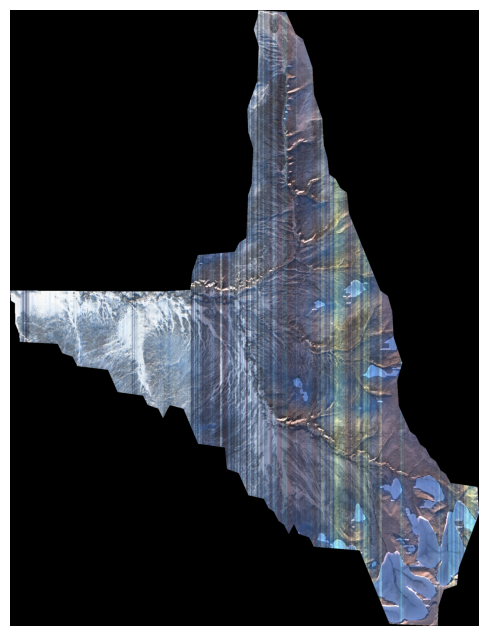

In [10]:
from sklearn.preprocessing import MinMaxScaler
# Function to scale image bands properly
def scale_band(band):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(band)  # Normalize between 0-1

# Assuming red_clipped, green_clipped, and blue_clipped are 2D NumPy arrays
rgb = np.dstack((scale_band(red_clipped.squeeze()),
    scale_band(green_clipped.squeeze()),
    scale_band(blue_clipped.squeeze()),
))

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(rgb)
plt.axis("off")
plt.show()